# HulC for Average Treatment Effect Estimation
In this page, we consider the coverage properties of HulC and adaptive HulC for ATE and compare its performance to Wald intervals.
\begin{equation*}
Y = \beta A + f(X) + \xi.
\end{equation*}

In [1]:
source("HulC.R")
library(sandwich)
library(mvtnorm)
library(grf)
suppressMessages(library("ggplot2"))
args(HulC)
args(adaptive_HulC)

Warning message:
"package 'mvtnorm' was built under R version 3.6.3"Warning message:
"package 'grf' was built under R version 3.6.3"

function (data, estimate, alpha = 0.05, Delta = 0, dim = 1, randomize = TRUE) 
NULL

function (data, estimate, alpha = 0.05, dim = 1, subsamp_exp = 2/3, 
    nsub = 1000, randomize = TRUE) 
NULL

In [2]:
HulC_larry = function(X,A,Y,alpha,ntrees=1000){
     n = length(Y)
     B = ceiling(log(2/alpha)/log(2))
     m = floor(n/B)
     Index = rep(1:B,rep(m,B))
     psi = rep(0,B)
     for(i in 1:B){
          I = (1:n)[Index == i]
          psi[i] = ATE(X[I],A[I],Y[I],alpha,ntrees)$psi
          }
     return(list(left=min(psi),right=max(psi)))
     }



splitdata = function(X,A,Y){
     X = as.matrix(X)
     n = nrow(X)
     m = floor(n/2)
     I = sample(1:n,size=m,replace=FALSE)
     J = setdiff(1:n,I)
     X1 = as.matrix(X[I,])
     Y1 = Y[I]
     A1 = A[I]
     X2 = as.matrix(X[J,])
     Y2 = Y[J]
     A2 = A[J]
     return(list(X1=X1,Y1=Y1,A1=A1,X2=X2,Y2=Y2,A2=A2))
     }





Forest = function(X,Y,ntrees=1000,Xtarget){
     ### fit Y = mu(X,A)
     ### train on (X,Y); get fitted values at Xtarget
     ### 
     X = as.matrix(X)
     Xtarget = as.matrix(Xtarget)
     tmp = regression_forest(X,Y,honesty = FALSE,num.trees=ntrees)
     out = predict(tmp,Xtarget)[,1]
     names(out) = NULL
     return(out)
     }



ATE = function(X,A,Y,alpha,ntrees=1000){
    z = -qnorm(alpha/2)
    tmp = splitdata(X,A,Y)
    X1 = as.matrix(tmp$X1)
    A1 = as.matrix(tmp$A1)
    Y1 = as.matrix(tmp$Y1)
    X2 = as.matrix(tmp$X2)
    A2 = as.matrix(tmp$A2)
    Y2 = as.matrix(tmp$Y2)

    m = nrow(X2)
    mu = Forest(X1,Y1,ntrees=ntrees,Xtarget=X2)  ##regress Y on X
    nu = Forest(X1,A1,ntrees=ntrees,Xtarget=X2)  ##regress A on X

    resY = Y2 - mu
    resA = A2 - nu

    tmp = lm(resY ~ 0 + resA)
    psi = tmp$coef
    se =  sqrt(vcovHC(tmp, type = "HC")[1,1])
#    se  = summary(tmp)$coef[1,2]
    left  = psi - z*se
    right = psi + z*se

    return(list(psi=psi,se=se,left=left,right=right))
    }

ATE_new = function(dat,ntrees=1000){
    dd <-  ncol(dat)
    X <- dat[,-c(dd-1, dd)]
    A <- dat[,dd-1]
    Y <- dat[,dd]
    tmp = splitdata(X,A,Y)
    X1 = as.matrix(tmp$X1)
    A1 = as.matrix(tmp$A1)
    Y1 = as.matrix(tmp$Y1)
    X2 = as.matrix(tmp$X2)
    A2 = as.matrix(tmp$A2)
    Y2 = as.matrix(tmp$Y2)

    m = nrow(X2)
    mu = Forest(X1,Y1,ntrees=ntrees,Xtarget=X2)  ##regress Y on X
    nu = Forest(X1,A1,ntrees=ntrees,Xtarget=X2)  ##regress A on X

    resY = Y2 - mu
    resA = A2 - nu

    tmp = lm(resY ~ 0 + resA)
    psi = tmp$coef
#     se =  sqrt(vcovHC(tmp, type = "HC")[1,1])
# #    se  = summary(tmp)$coef[1,2]
#     left  = psi - z*se
#     right = psi + z*se

    return(psi)
}








In [4]:
set.seed(1)
n = 1000
a = 1
beta = 2
d = 2
A = rnorm(n)
X = matrix(rnorm(n*d),n,d)
X = X + A
Y = beta*A + 3*X[,1] + 3*X[,2]^2 + rnorm(n)
data  <- cbind(X, A, Y)
cat("HulC with randomized number of splits\n")
HulC(data, ATE_new)
cat("HulC without randomized number of splits\n")
HulC(data, ATE_new, randomize = FALSE)
cat("Adaptive HulC with randomized number of splits\n")
adaptive_HulC(data, ATE_new)

HulC with randomized number of splits


lwr,upr
2.109198,5.059347


HulC without randomized number of splits


lwr,upr
2.087167,5.181793


Adaptive HulC with randomized number of splits


lwr,upr
1.273704,2.977353


[1] 0.71
[1] 0.94


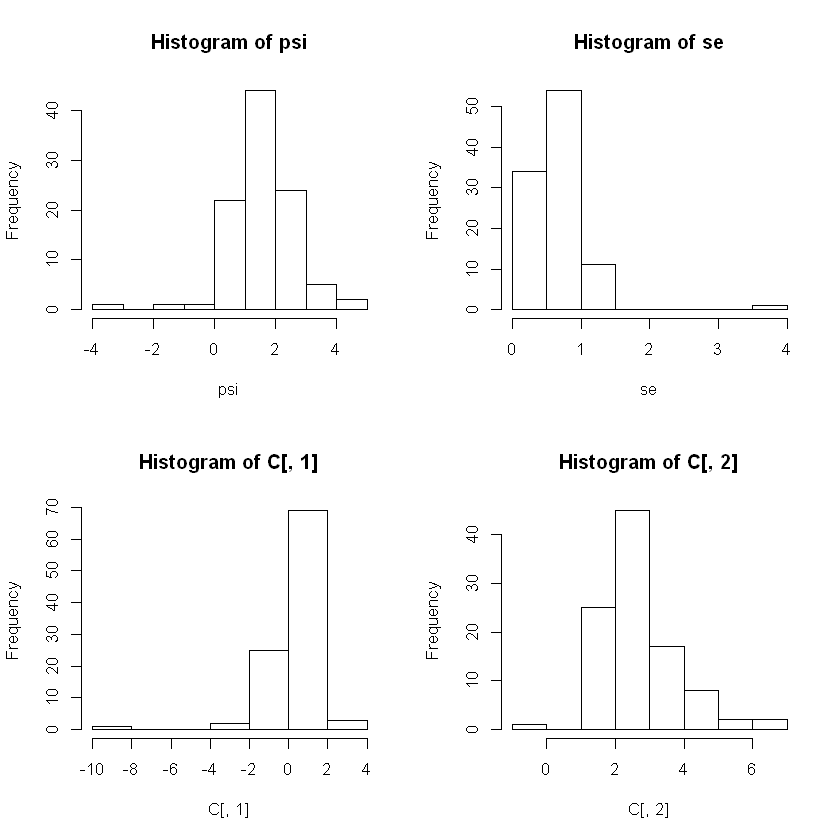

In [14]:
nsim = 100
alpha = .1

set.seed(111)

### low dimensional example
coverage = 0
coverage_hulc = 0
n = 1000
a = 1
beta = 2
C = matrix(0,nsim,2)
psi = rep(0,nsim)
se = rep(0,nsim)
d = 20
for(i in 1:nsim){
# cat(i,"  out of ",nsim,"\n")
     A = rnorm(n)
     X = matrix(rnorm(n*d),n,d)
     X = X + A
     Y = beta*A + 3*X[,1] + 3*X[,2]^2 + rnorm(n)
     out = ATE(X,A,Y,alpha)
     if( (out$left <= beta) & (beta <= out$right) )coverage = coverage + (1/nsim)
     C[i,] = c(out$left,out$right)
     psi[i] = out$psi
     se[i] = out$se
#      out = HulC_larry(X,A,Y,alpha)
    out = adaptive_HulC(cbind(X, A, Y), ATE_new, alpha, nsub = 200)
    CI <- out$CI
#     print(out)
     if( (CI[,"lwr"] <= beta) & (beta <= CI[,"upr"]) )coverage_hulc = coverage_hulc + (1/nsim)
     }
print(coverage)
print(coverage_hulc)
par(mfrow=c(2,2))
hist(psi)
hist(se)
hist(C[,1])
hist(C[,2])